In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import contract_18_decimals_to_float

import warnings
warnings.filterwarnings('ignore')

# Conclusions after performing all of the work shown below

```open_orders, makers, liquidity_changes, withdraws, deposits``` tables contain makers information and using those tables it is possible to track all changes, activity and performance of makers

In [3]:
tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

# Collecting all the data

In [4]:
liquidity_changes_df = pd.read_csv("liquidity_changes.csv")
liquidity_changes_df.drop(columns=["Unnamed: 0", "quote_token"], inplace=True)
liquidity_changes_df["time"] = pd.to_datetime(liquidity_changes_df["timestamp"], unit='s')
liquidity_changes_df["day_of_year"] = liquidity_changes_df["time"].dt.dayofyear
liquidity_changes_df["pool_name"] = liquidity_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
liquidity_changes_df.drop(columns=["base_token"], inplace=True)
liquidity_changes_df["lower_bound"] = pow(1.0001, liquidity_changes_df["lower_tick"])
liquidity_changes_df["upper_bound"] = pow(1.0001, liquidity_changes_df["upper_tick"])
liquidity_changes_df["central_bound"] = (liquidity_changes_df["upper_bound"] + liquidity_changes_df["lower_bound"]) / 2

In [5]:
makers_df = pd.read_csv("makers.csv")
makers_df.drop(columns=["Unnamed: 0"], inplace=True)
makers_df["time"] = pd.to_datetime(makers_df["timestamp"], unit='s')

In [6]:
open_orders_df = pd.read_csv("open_orders.csv")
open_orders_df["time"] = pd.to_datetime(open_orders_df["timestamp"], unit='s')
open_orders_df["pool_name"] = open_orders_df["base_token"].replace(tokens_addresses_to_names_dict)
open_orders_df.drop(columns=["Unnamed: 0", "base_token"], inplace=True)
open_orders_df["lower_bound"] = pow(1.0001, open_orders_df["lower_tick"])
open_orders_df["upper_bound"] = pow(1.0001, open_orders_df["upper_tick"])

# Preparation of the open orders

Conform the information from subgraph ```id``` in ```open_order``` table has next format:

```maker_address``` => ```base_token_address``` => ```lower_tick``` => ```upper_tick```,

where all those elements are separated by the ```-``` sign. Therefore it is possible to perform extraction of those fields.

In [7]:
open_orders_df["maker"] = [order.split("-")[0] for order in open_orders_df["id"]]
open_orders_df

,id,lower_tick,upper_tick,liquidity,collected_fee,collected_fee_in_lifecycle,block_number,timestamp,time,pool_name,lower_bound,upper_bound,maker
0,0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...,82560,83280,0,0.092905,0.0,519810,1638012541,2021-11-27 11:29:01,vETH,3849.071493,4136.410359,0xb3344d84ad8dd6b96301991bf12dc739e226c9cf
1,0x35952141922ee99a04e016c967c3f0ad589ea958-0x8...,82920,83640,0,0.817147,0.0,524763,1638026591,2021-11-27 15:23:11,vETH,3990.155285,4288.026265,0x35952141922ee99a04e016c967c3f0ad589ea958
2,0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...,109020,109200,0,9.275207,0.0,539423,1638065839,2021-11-28 02:17:19,vBTC,54255.244326,55240.631335,0x98029c23e4a554989c280de7fcb1c2ededf2b17f
3,0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...,108780,109080,0,0.272230,0.0,547656,1638084887,2021-11-28 07:34:47,vBTC,52968.683273,54581.737969,0x98029c23e4a554989c280de7fcb1c2ededf2b17f
4,0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...,108840,109080,0,0.322718,0.0,551150,1638093044,2021-11-28 09:50:44,vBTC,53287.434734,54581.737969,0x98029c23e4a554989c280de7fcb1c2ededf2b17f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...,-7920,14040,1014000531006066466095914,545.656108,0.0,9055973,1653578963,2022-05-26 15:29:23,vSAND,0.452956,4.071167,0x3c2be159678c6bc641a2852e2e6d95759a024241
14602,0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae-0x3...,5760,27720,512139583146431454950415,80.704259,0.0,9056064,1653579027,2022-05-26 15:30:27,vNEAR,1.778857,15.988367,0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae
14603,0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae-0x3...,5880,27840,0,35.541399,0.0,9056074,1653579027,2022-05-26 15:30:27,vNEAR,1.800331,16.181374,0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae
14604,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x5...,11820,33780,377987196027223073127996,38.161808,0.0,9056084,1653579042,2022-05-26 15:30:42,vATOM,3.260697,29.307138,0x3c2be159678c6bc641a2852e2e6d95759a024241


# Searching inner connections by addresses

In [8]:
chosen_address = "0x3c2be159678c6bc641a2852e2e6d95759a024241"
liquidity_changes_df[liquidity_changes_df["maker"] == chosen_address]

,id,tx_hash,maker,lower_tick,upper_tick,base,quote,liquidity,quote_fee,from_function_signature,block_number_log_index,block_number,timestamp,time,day_of_year,pool_name,lower_bound,upper_bound,central_bound


In [9]:
makers_df[makers_df["id"] == chosen_address]

,id,collected_fee,block_number,timestamp,time
1292,0x3c2be159678c6bc641a2852e2e6d95759a024241,45905.312362,9046156,1653571307,2022-05-26 13:21:47


In [10]:
open_orders_df[open_orders_df["maker"] == chosen_address]

,id,lower_tick,upper_tick,liquidity,collected_fee,collected_fee_in_lifecycle,block_number,timestamp,time,pool_name,lower_bound,upper_bound,maker
12550,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...,-7140,14820,0,0.595071,0.0,8149276,1652442485,2022-05-13 11:48:05,vSAND,0.489699,4.401414,0x3c2be159678c6bc641a2852e2e6d95759a024241
12555,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x1...,28500,50460,0,39.241691,0.0,8150597,1652443201,2022-05-13 12:00:01,vSOL,17.285319,155.360421,0x3c2be159678c6bc641a2852e2e6d95759a024241
12616,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...,-7980,14040,0,84.609627,0.0,8206995,1652491321,2022-05-14 01:22:01,vSAND,0.450246,4.071167,0x3c2be159678c6bc641a2852e2e6d95759a024241
12633,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...,-7320,14700,0,56.070264,0.0,8217118,1652502647,2022-05-14 04:30:47,vSAND,0.480964,4.348916,0x3c2be159678c6bc641a2852e2e6d95759a024241
12711,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x1...,27420,49440,0,430.408186,0.0,8262905,1652545879,2022-05-14 16:31:19,vSOL,15.515863,140.295767,0x3c2be159678c6bc641a2852e2e6d95759a024241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14599,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x1...,27180,49140,0,44.822474,0.0,9055951,1653578931,2022-05-26 15:28:51,vSOL,15.147933,136.149605,0x3c2be159678c6bc641a2852e2e6d95759a024241
14600,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...,-7800,14160,0,294.447284,0.0,9055977,1653578963,2022-05-26 15:29:23,vSAND,0.458424,4.120313,0x3c2be159678c6bc641a2852e2e6d95759a024241
14601,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...,-7920,14040,1014000531006066466095914,545.656108,0.0,9055973,1653578963,2022-05-26 15:29:23,vSAND,0.452956,4.071167,0x3c2be159678c6bc641a2852e2e6d95759a024241
14604,0x3c2be159678c6bc641a2852e2e6d95759a024241-0x5...,11820,33780,377987196027223073127996,38.161808,0.0,9056084,1653579042,2022-05-26 15:30:42,vATOM,3.260697,29.307138,0x3c2be159678c6bc641a2852e2e6d95759a024241


Check for another address

In [11]:
makers_df.sort_values("collected_fee")

,id,collected_fee,block_number,timestamp,time
318,0xd59173810b8f94b97150470d590723503adbeb39,0.000000e+00,4402582,1647136950,2022-03-13 02:02:30
995,0x5a8ac83950e00f75416938bc98f4b7ca2735eaca,0.000000e+00,8267303,1652548824,2022-05-14 17:20:24
389,0xc9439f9d11bee50cb268522bd2a0590667925474,0.000000e+00,4696829,1647925713,2022-03-22 05:08:33
994,0xe50f197c7d4fa60c444f85bd2eff2bf4f936a0a3,0.000000e+00,8265540,1652547264,2022-05-14 16:54:24
993,0x2782ba91c1ff0f97209ee91aa5a23b88f88833ee,0.000000e+00,8262167,1652545378,2022-05-14 16:22:58
...,...,...,...,...,...
1036,0xe77dd81813bd06d74a30d1b2c07418906456498e,4.903811e+05,8390159,1652691732,2022-05-16 09:02:12
970,0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd,5.053723e+05,8155675,1652446643,2022-05-13 12:57:23
1074,0x70332de459d5554a9a310a7c4f7c6069c73604f9,7.413193e+05,8502253,1652841898,2022-05-18 02:44:58
398,0xf8489bcef22d3282bb884b9e9cc708bb465c075e,1.105782e+06,4780632,1648102857,2022-03-24 06:20:57


In [12]:
chosen_address = "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7"
liquidity_changes_df[liquidity_changes_df["maker"] == chosen_address]

,id,tx_hash,maker,lower_tick,upper_tick,base,quote,liquidity,quote_fee,from_function_signature,block_number_log_index,block_number,timestamp,time,day_of_year,pool_name,lower_bound,upper_bound,central_bound
0,0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...,0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,82680,83700,46.254982,200000.000000,120851329740116430743586,0.000000,0xc35eb28c,515557003,515557,1638000985,2021-11-27 08:16:25,331,vETH,3.895536e+03,4.313830e+03,4.104683e+03
1,0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...,0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,-887220,887220,0.012181,50.000000,780406707692264026,0.000000,0xc35eb28c,515554004,515554,1638000985,2021-11-27 08:16:25,331,vETH,2.954278e-39,3.384921e+38,1.692461e+38
2,0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...,0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,108540,109500,3.572179,200000.000000,35648835496586206981164,0.000000,0xc35eb28c,515555003,515555,1638000985,2021-11-27 08:16:25,331,vBTC,5.171263e+04,5.692287e+04,5.431775e+04
3,0xec1e410b931f920c4aa3ae105e63463142b310fbe959...,0xec1e410b931f920c4aa3ae105e63463142b310fbe959...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,-887220,887220,0.000921,50.000000,214579018294735723,0.000000,0xc35eb28c,515552004,515552,1638000985,2021-11-27 08:16:25,331,vBTC,2.954278e-39,3.384921e+38,1.692461e+38
22,0x1c761e2266b87c9f047eab4a996e1bfc38855f1ad397...,0x1c761e2266b87c9f047eab4a996e1bfc38855f1ad397...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,108900,109860,3.255201,200000.000000,34058767588640924916884,0.000000,0xc35eb28c,568711003,568711,1638135861,2021-11-28 21:44:21,332,vBTC,5.360810e+04,5.900932e+04,5.630871e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17248,0x1f2de8e6db9b4796953e1b7ad01d5a72127d187f4104...,0x1f2de8e6db9b4796953e1b7ad01d5a72127d187f4104...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,104100,109320,-0.001449,-62.354889,-2456931293980644627,0.000000,0xcde109b6,4787801007,4787801,1648112797,2022-03-24 09:06:37,83,vBTC,3.317260e+04,5.590748e+04,4.454004e+04
17253,0x859b22078e59214e23801fc997b555cc16462a65226c...,0x859b22078e59214e23801fc997b555cc16462a65226c...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,104100,109320,2.902825,124926.543699,4922403691365585770616,0.000000,0xc35eb28c,4787814006,4787814,1648112813,2022-03-24 09:06:53,83,vBTC,3.317260e+04,5.590748e+04,4.454004e+04
17294,0x4df543f555e12c717dc18fd867d83ec4ef474c6a82ff...,0x4df543f555e12c717dc18fd867d83ec4ef474c6a82ff...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,104040,109320,2.838812,125000.000000,4817792843813920530960,0.000000,0xc35eb28c,4789248005,4789248,1648114625,2022-03-24 09:37:05,83,vBTC,3.297417e+04,5.590748e+04,4.444082e+04
17295,0xbef90ed69acaf7408248593ce1ada8d371aa457c2bf3...,0xbef90ed69acaf7408248593ce1ada8d371aa457c2bf3...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,104100,109320,-2.884910,-125698.570007,-4922403691365585770616,14.853304,0xcde109b6,4789274008,4789274,1648114640,2022-03-24 09:37:20,83,vBTC,3.317260e+04,5.590748e+04,4.454004e+04


In [13]:
makers_df[makers_df["id"] == chosen_address]

,id,collected_fee,block_number,timestamp,time
400,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,1.949788e+06,4791478,1648117106,2022-03-24 10:18:26


In [14]:
open_orders_df[open_orders_df["maker"] == chosen_address]

,id,lower_tick,upper_tick,liquidity,collected_fee,collected_fee_in_lifecycle,block_number,timestamp,time,pool_name,lower_bound,upper_bound,maker
8,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,108540,109500,0,761.152618,0.0,568721,1638135861,2021-11-28 21:44:21,vBTC,5.171263e+04,5.692287e+04,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
9,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,82680,83700,0,1274.094969,0.0,568864,1638136192,2021-11-28 21:49:52,vETH,3.895536e+03,4.313830e+03,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
14,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,-887220,887220,0,0.006881,0.0,582490,1638178819,2021-11-29 09:40:19,vBTC,2.954278e-39,3.384921e+38,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
15,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,-887220,887220,0,0.010864,0.0,582496,1638178890,2021-11-29 09:41:30,vETH,2.954278e-39,3.384921e+38,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
16,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,83100,84120,0,512.590286,0.0,599118,1638230889,2021-11-30 00:08:09,vETH,4.062625e+03,4.498861e+03,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,104100,109380,0,3.823265,0.0,4770077,1648084516,2022-03-24 01:15:16,vBTC,3.317260e+04,5.624392e+04,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
3128,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,103980,109260,0,17.038636,0.0,4777452,1648096617,2022-03-24 04:36:57,vBTC,3.277693e+04,5.557305e+04,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
3135,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,104040,109260,0,23.509620,0.0,4779798,1648101877,2022-03-24 06:04:37,vBTC,3.297417e+04,5.557305e+04,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
3150,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7-0x8...,104100,109320,0,79.992613,0.0,4789274,1648114640,2022-03-24 09:37:20,vBTC,3.317260e+04,5.590748e+04,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7


In [15]:
liquidity_changes_df["modified_liquidity"] = [contract_18_decimals_to_float(change) for change 
                                              in liquidity_changes_df["liquidity"]]
liquidity_changes_df

,id,tx_hash,maker,lower_tick,upper_tick,base,quote,liquidity,quote_fee,from_function_signature,block_number_log_index,block_number,timestamp,time,day_of_year,pool_name,lower_bound,upper_bound,central_bound,modified_liquidity
0,0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...,0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,82680,83700,46.254982,200000.000000,120851329740116430743586,0.000000,0xc35eb28c,515557003,515557,1638000985,2021-11-27 08:16:25,331,vETH,3.895536e+03,4.313830e+03,4.104683e+03,1.208513e+05
1,0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...,0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,-887220,887220,0.012181,50.000000,780406707692264026,0.000000,0xc35eb28c,515554004,515554,1638000985,2021-11-27 08:16:25,331,vETH,2.954278e-39,3.384921e+38,1.692461e+38,7.804067e-01
2,0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...,0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,108540,109500,3.572179,200000.000000,35648835496586206981164,0.000000,0xc35eb28c,515555003,515555,1638000985,2021-11-27 08:16:25,331,vBTC,5.171263e+04,5.692287e+04,5.431775e+04,3.564884e+04
3,0xec1e410b931f920c4aa3ae105e63463142b310fbe959...,0xec1e410b931f920c4aa3ae105e63463142b310fbe959...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,-887220,887220,0.000921,50.000000,214579018294735723,0.000000,0xc35eb28c,515552004,515552,1638000985,2021-11-27 08:16:25,331,vBTC,2.954278e-39,3.384921e+38,1.692461e+38,2.145790e-01
4,0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...,0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...,0x35952141922ee99a04e016c967c3f0ad589ea958,82920,83640,0.100000,472.798469,386315245282791945890,0.000000,0xc35eb28c,516478004,516478,1638003992,2021-11-27 09:06:32,331,vETH,3.990155e+03,4.288026e+03,4.139091e+03,3.863152e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95645,0x3c94355621ea01688d374d07da032f57f3ec04480187...,0x3c94355621ea01688d374d07da032f57f3ec04480187...,0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd,45120,47040,-2470.572327,-248190.110460,-528387530374088819323470,0.000000,0xcde109b6,6654324008,6654324,1651142059,2022-04-28 10:34:19,118,vSOL,9.108329e+01,1.103619e+02,1.007226e+02,-5.283875e+05
95646,0x19a82695df86a912368aac959536f93262c39cfe02f6...,0x19a82695df86a912368aac959536f93262c39cfe02f6...,0xe77dd81813bd06d74a30d1b2c07418906456498e,8460,10380,-204626.160511,-454278.053108,-6522007735030680945024298,58.114949,0xcde109b6,6654380006,6654380,1651142170,2022-04-28 10:36:10,118,vSAND,2.330208e+00,2.823418e+00,2.576813e+00,-6.522008e+06
95647,0xda223d45899d4d3e9e39a193dbbda700edde88110101...,0xda223d45899d4d3e9e39a193dbbda700edde88110101...,0xe77dd81813bd06d74a30d1b2c07418906456498e,8400,10320,49063.646978,123088.079928,1658298770984291147556810,0.000000,0xc35eb28c,6654370006,6654370,1651142170,2022-04-28 10:36:10,118,vSAND,2.316270e+00,2.806529e+00,2.561399e+00,1.658299e+06
95648,0x716065511888b305590bf64cb26fba2f2270d26453c8...,0x716065511888b305590bf64cb26fba2f2270d26453c8...,0x70332de459d5554a9a310a7c4f7c6069c73604f9,-960,960,487306.142879,500000.000000,10533713373586645166672268,0.000000,0xc35eb28c,6654565006,6654565,1651142607,2022-04-28 10:43:27,118,vFTM,9.084684e-01,1.100754e+00,1.004611e+00,1.053371e+07


# Showing results for top 10 makers conform collected fees

In [16]:
top_makers = makers_df.sort_values("collected_fee").tail(10)["id"]

Considering that charts are noisy it would be great to make a daily mean

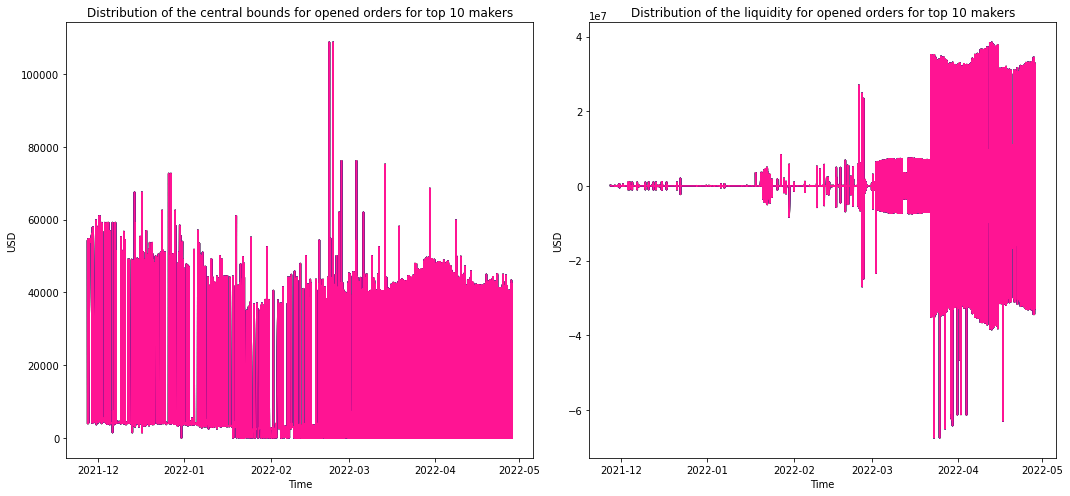

In [17]:
colors = ["red", "orange", "olivedrab", "darkgreen", "lightseagreen", 
          "deepskyblue", "slategray", "purple", "navy", "deeppink"]
fig = plt.figure(figsize=(15, 7))
index = 0

for maker in top_makers:
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(liquidity_changes_df[liquidity_changes_df["central_bound"] < 10000000]["time"], 
            liquidity_changes_df[liquidity_changes_df["central_bound"] < 10000000]["central_bound"], color=colors[index], label=maker)
    ax.set_xlabel("Time")
    ax.set_ylabel("USD")
    ax.set_title("Distribution of the central bounds for opened orders for top 10 makers")
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(liquidity_changes_df["time"], liquidity_changes_df["modified_liquidity"], color=colors[index], label=maker)
    ax.set_xlabel("Time")
    ax.set_ylabel("USD")
    ax.set_title("Distribution of the liquidity for opened orders for top 10 makers")
    
    index += 1

fig.tight_layout()
plt.show()

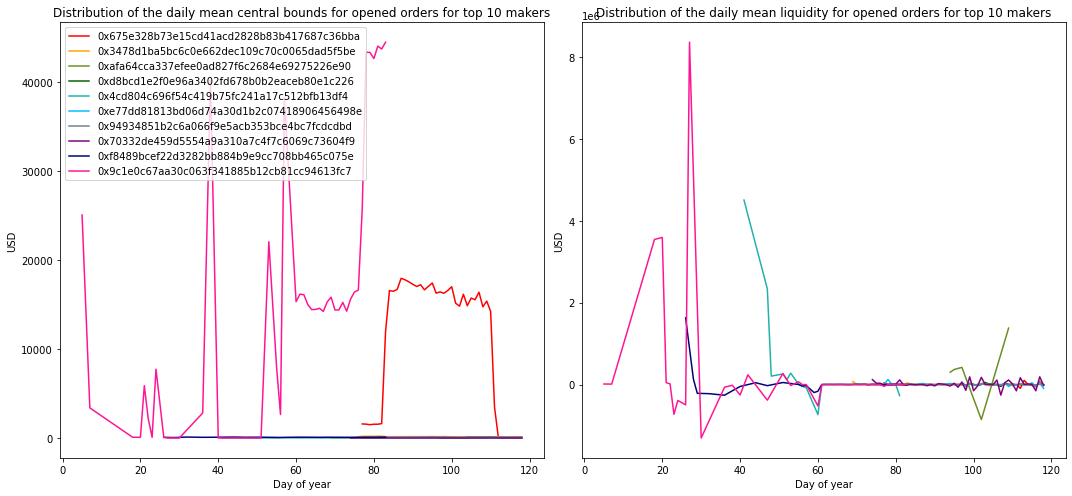

In [18]:
colors = ["red", "orange", "olivedrab", "darkgreen", "lightseagreen", 
          "deepskyblue", "slategray", "purple", "navy", "deeppink"]
fig = plt.figure(figsize=(15, 7))
index = 0

for maker in top_makers:
    maker_liquidity_changes_df = liquidity_changes_df[liquidity_changes_df["maker"] == maker]
    grouped_mean_liquidity_changes_df = maker_liquidity_changes_df[["day_of_year", "central_bound", 
                                                                    "modified_liquidity"]].groupby("day_of_year"
                                                                                                   ).mean()
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(grouped_mean_liquidity_changes_df[grouped_mean_liquidity_changes_df.index < 200].index, 
            grouped_mean_liquidity_changes_df[grouped_mean_liquidity_changes_df.index < 200]["central_bound"], 
            color=colors[index], label=maker)
    ax.set_xlabel("Day of year")
    ax.set_ylabel("USD")
    ax.set_title("Distribution of the daily mean central bounds for opened orders for top 10 makers")
    ax.legend()
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(grouped_mean_liquidity_changes_df[grouped_mean_liquidity_changes_df.index < 200].index, 
            grouped_mean_liquidity_changes_df[grouped_mean_liquidity_changes_df.index < 200]["modified_liquidity"], 
            color=colors[index], label=maker)
    ax.set_xlabel("Day of year")
    ax.set_ylabel("USD")
    ax.set_title("Distribution of the daily mean liquidity for opened orders for top 10 makers")
    ax.legend
    
    index += 1

fig.tight_layout()
plt.show()

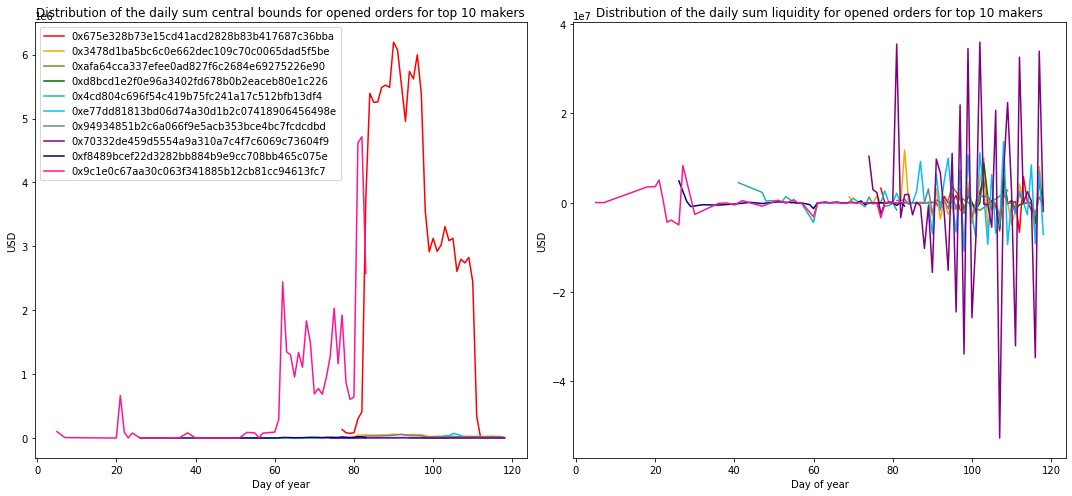

In [19]:
colors = ["red", "orange", "olivedrab", "darkgreen", "lightseagreen", 
          "deepskyblue", "slategray", "purple", "navy", "deeppink"]
fig = plt.figure(figsize=(15, 7))
index = 0

for maker in top_makers:
    maker_liquidity_changes_df = liquidity_changes_df[liquidity_changes_df["maker"] == maker]
    grouped_sum_liquidity_changes_df = maker_liquidity_changes_df[["day_of_year", "central_bound", 
                                                                    "modified_liquidity"]].groupby("day_of_year"
                                                                                                   ).sum()
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(grouped_sum_liquidity_changes_df[grouped_sum_liquidity_changes_df.index < 200].index, 
            grouped_sum_liquidity_changes_df[grouped_sum_liquidity_changes_df.index < 200]["central_bound"], 
            color=colors[index], label=maker)
    ax.set_xlabel("Day of year")
    ax.set_ylabel("USD")
    ax.set_title("Distribution of the daily sum central bounds for opened orders for top 10 makers")
    ax.legend()
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(grouped_sum_liquidity_changes_df[grouped_sum_liquidity_changes_df.index < 200].index, 
            grouped_sum_liquidity_changes_df[grouped_sum_liquidity_changes_df.index < 200]["modified_liquidity"], 
            color=colors[index], label=maker)
    ax.set_xlabel("Day of year")
    ax.set_ylabel("USD")
    ax.set_title("Distribution of the daily sum liquidity for opened orders for top 10 makers")
    ax.legend
    
    index += 1

fig.tight_layout()
plt.show()

# Check of connection between makers and liquidations

In [20]:
liquidations_df = pd.read_csv("position_liquidations.csv")
liquidations_df.drop(columns=["Unnamed: 0"], inplace=True)
liquidations_df["time"] = pd.to_datetime(liquidations_df["timestamp"], unit='s')
liquidations_df["pool_name"] = liquidations_df["base_token"].replace(tokens_addresses_to_names_dict)
liquidations_df.drop(columns=["base_token"], inplace=True)
liquidations_df

,tx_hash,trader,liquidator,liquidation_fee,position_size_abs,position_notional_abs,block_number,timestamp,time,pool_name
0,0xf29899730b11a5753acfd2aa76323a00cc5138bc0432...,0x98029c23e4a554989c280de7fcb1c2ededf2b17f,0x5b3b3ed2bc7e643f6b558237e7c488e6b32eed80,48.873227,0.453003,1954.929064,571747,1638141748,2021-11-28 23:22:28,vETH
1,0x94eec0d2531abdd25a4114cff480dda1d42e1b5624af...,0x499166d1a71fed3b490ddb0591f4ae14c1031993,0x4680cca73f815b583a201afef4b70451fb53b7af,138.828968,0.096288,5553.158726,572724,1638144236,2021-11-29 00:03:56,vBTC
2,0x5dfcb2f5856e4df95701ac6142b20e7e491314119693...,0x35952141922ee99a04e016c967c3f0ad589ea958,0x5b3b3ed2bc7e643f6b558237e7c488e6b32eed80,15.017667,0.010330,600.706678,573466,1638145638,2021-11-29 00:27:18,vBTC
3,0xc8f54890f82e3b91f802c221765b025a8c119c498fbb...,0xd087966b4d2b1841c88b4d62b407d5ef1a465ac3,0x5b3b3ed2bc7e643f6b558237e7c488e6b32eed80,121.233376,0.083333,4849.335035,573632,1638145930,2021-11-29 00:32:10,vBTC
4,0x71bfc81fe97adc1e8d4f783ec56fd9fa6bc1d024602c...,0x35952141922ee99a04e016c967c3f0ad589ea958,0x5b3b3ed2bc7e643f6b558237e7c488e6b32eed80,66.776190,0.608888,2671.047610,574411,1638147791,2021-11-29 01:03:11,vETH
...,...,...,...,...,...,...,...,...,...,...
2540,0x8523d14e61979f8f87b0c3569eaf8aab2ef3d9b01899...,0xfdfb146bff194e53661f18b9a1ffa60da9107d19,0xdcf93a1eacfe39f04e07c04cf7315412133c6167,0.019161,0.209677,0.766425,6521223,1651005360,2022-04-26 20:36:00,vPERP
2541,0xed14065a5857d170d00e896bf69a8e13e45a52511599...,0x95f6acd42d85d699d2a8066d0237f13a9e82a29a,0x40fac6b96c112d1339e4243d856dc31ce2be2034,101.445011,320.067886,4057.800458,6530813,1651015372,2022-04-26 23:22:52,vNEAR
2542,0xd560824df8505cd433c4a5fca89c7297ccf4c209e14c...,0x00ccef1f2c02a986841a6eece88451be8f86958d,0x2f06b6fbd4ce2139e01a1bee7154b79f898c0dd4,10.841782,4333.852636,433.671287,6532058,1651016226,2022-04-26 23:37:06,vONE
2543,0x95e959c4b7a22d5bf3acaa3bb63e6542b7977c760f6c...,0xc0b2b0d1ed3d743f409b65821abfd0d249a46bce,0xdcf93a1eacfe39f04e07c04cf7315412133c6167,0.191831,0.000196,7.673236,6579040,1651047633,2022-04-27 08:20:33,vBTC


There are not top makers detected in the liquidations section and therefore it means that there are no trading positions closed by those makers.

In [21]:
liquidations_df[liquidations_df["trader"].isin(top_makers)]["trader"].unique()

array([], dtype=object)

In [22]:
liquidations_df[liquidations_df["liquidator"].isin(top_makers)]["liquidator"].unique()

array([], dtype=object)

# Check of connection between makers and withdraws

```collateral_token``` will be dropped because there are one and the same record

In [23]:
withdraws_df = pd.read_csv("withdraws.csv")
withdraws_df.drop(columns=["Unnamed: 0", "collateral_token"], inplace=True)
withdraws_df["time"] = pd.to_datetime(withdraws_df["timestamp"], unit='s')
withdraws_df

,id,tx_hash,trader,amount,block_number_log_index,block_number,timestamp,time
0,0x523a7a44bc2ccee84ae8337949db01ef4b5268f420e0...,0x523a7a44bc2ccee84ae8337949db01ef4b5268f420e0...,0x499166d1a71fed3b490ddb0591f4ae14c1031993,173.323015,575084001,575084,1638150257,2021-11-29 01:44:17
1,0x29583b942fdaf2f39c3ef38fbc18e6ade9c7edc73715...,0x29583b942fdaf2f39c3ef38fbc18e6ade9c7edc73715...,0x4ffef86586e730bd8e848708124c105d8f01ba7d,1418.636005,578836001,578836,1638166466,2021-11-29 06:14:26
2,0x6b7a65b92feaaa0e61acda8d53ff7bffd97c5353a796...,0x6b7a65b92feaaa0e61acda8d53ff7bffd97c5353a796...,0x2441434f47e511a13714d8f7ae60dd923b1cfadd,681.426360,578875001,578875,1638166558,2021-11-29 06:15:58
3,0x7f694a7478ca8f244e9764c3561de318bb48d9c9edb4...,0x7f694a7478ca8f244e9764c3561de318bb48d9c9edb4...,0x27fee0c6356c2f27e646d73f2256d30331c6a001,499.951236,578895001,578895,1638166558,2021-11-29 06:15:58
4,0x85b233912d3f34b064fb1b0396878787f1f9ae6c33f6...,0x85b233912d3f34b064fb1b0396878787f1f9ae6c33f6...,0xf2cd72adf27aea9808152a93dab9092e89163fb5,688.383929,579467001,579467,1638168684,2021-11-29 06:51:24
...,...,...,...,...,...,...,...,...
11092,0x68d5bc9de659586a53f187d785fed4c2d8f2e19f0c52...,0x68d5bc9de659586a53f187d785fed4c2d8f2e19f0c52...,0xe7a4e7a1416ba6cc84cb5a3afd1daa0c7ef1bf29,1.000000,6644267007,6644267,1651129811,2022-04-28 07:10:11
11093,0xb33558190b5397402bcdf1435e0d14302727b62debb7...,0xb33558190b5397402bcdf1435e0d14302727b62debb7...,0xb92506efc3b9e33a3e4f313a79436e9883f92b18,1.993989,6644460001,6644460,1651129989,2022-04-28 07:13:09
11094,0xae48a71e7e35542803006935abc05b3de2035380721a...,0xae48a71e7e35542803006935abc05b3de2035380721a...,0x0df2a3b9e5b8ac060b73654c0b7d77ad7dae572f,1.994002,6647256001,6647256,1651133305,2022-04-28 08:08:25
11095,0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...,0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...,0xfdf3b3b1cfe5f4967daba1719693d589ba790c1c,1369.706620,6650269001,6650269,1651136454,2022-04-28 09:00:54


In [30]:
withdraws_df["amount"].sum()

42670682.063575

Out of the top 10 makers on the platform there are only 7 present, meaning that 3 persons were not participating in the withdraws

In [24]:
withdraws_df[withdraws_df["trader"].isin(top_makers)]["trader"].unique()

array(['0x9c1e0c67aa30c063f341885b12cb81cc94613fc7',
       '0xf8489bcef22d3282bb884b9e9cc708bb465c075e',
       '0x4cd804c696f54c419b75fc241a17c512bfb13df4',
       '0x675e328b73e15cd41acd2828b83b417687c36bba',
       '0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be',
       '0x70332de459d5554a9a310a7c4f7c6069c73604f9',
       '0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd'], dtype=object)

# Check for connection with deposits

```collateral_token``` is removed becaused of the only record used in the dataset, meaning that there is no need in collateral token representation at the current stage

In [25]:
deposits_df = pd.read_csv("deposits.csv")
deposits_df.drop(columns=["Unnamed: 0", "collateral_token"], inplace=True)
deposits_df["time"] = pd.to_datetime(deposits_df["timestamp"], unit='s')
deposits_df

,id,tx_hash,trader,amount,block_number_log_index,block_number,timestamp,time
0,0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...,0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,250000.000000,515551002,515551,1638000985,2021-11-27 08:16:25
1,0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...,0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...,0x98029c23e4a554989c280de7fcb1c2ededf2b17f,500.000000,516284002,516284,1638002723,2021-11-27 08:45:23
2,0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...,0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...,0x1313817a82545e29764281f51f6255619753235d,500.000000,516348002,516348,1638003246,2021-11-27 08:54:06
3,0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...,0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...,0xd087966b4d2b1841c88b4d62b407d5ef1a465ac3,500.000000,516415002,516415,1638003538,2021-11-27 08:58:58
4,0x02288555584fe8d00e6e4c596d286544647666a01eed...,0x02288555584fe8d00e6e4c596d286544647666a01eed...,0xc9735c7e0015fc9719f28306f90e530420f9b4ef,500.000000,516446002,516446,1638003768,2021-11-27 09:02:48
...,...,...,...,...,...,...,...,...
21016,0xcd72a3fe1192f075248bc0b7b1fd6ceaad5ede14c72b...,0xcd72a3fe1192f075248bc0b7b1fd6ceaad5ede14c72b...,0xdc727e98cb97550b04b9b370b7286f98fd6ce832,20000.000000,6646514002,6646514,1651132541,2022-04-28 07:55:41
21017,0x4ad7077af869eda9458544bfcdbd456191e5ffdcca97...,0x4ad7077af869eda9458544bfcdbd456191e5ffdcca97...,0x0df2a3b9e5b8ac060b73654c0b7d77ad7dae572f,2.000000,6646785002,6646785,1651132867,2022-04-28 08:01:07
21018,0x5bf8f49846db7e917619a95f8804c4a48b1e0761f68e...,0x5bf8f49846db7e917619a95f8804c4a48b1e0761f68e...,0xbd96a914e932aff88a8529fb86d49314c6fafcea,14631.276264,6652910002,6652910,1651140296,2022-04-28 10:04:56
21019,0x60c2c44ade6c07a1845b4103e110dbd2a1082f074164...,0x60c2c44ade6c07a1845b4103e110dbd2a1082f074164...,0xbb20d477d4f22d7169ad4c5bd67984362be8bad0,146.497910,6653693002,6653693,1651141101,2022-04-28 10:18:21


In [26]:
deposits_df[deposits_df["trader"].isin(top_makers)]

,id,tx_hash,trader,amount,block_number_log_index,block_number,timestamp,time
0,0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...,0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,2.500000e+05,515551002,515551,1638000985,2021-11-27 08:16:25
27,0x2152da832c3dcdc98fbfda3836ce7fc52748ee827363...,0x2152da832c3dcdc98fbfda3836ce7fc52748ee827363...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,1.550000e+06,609871002,609871,1638261392,2021-11-30 08:36:32
74,0xde3cff011b36a41947aed2520f2baab7bae17a2c6ae0...,0xde3cff011b36a41947aed2520f2baab7bae17a2c6ae0...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,1.000000e+06,648648002,648648,1638353434,2021-12-01 10:10:34
698,0x2ee93771916e1ba85abb02f93ad19c82084c4cb2ec8f...,0x2ee93771916e1ba85abb02f93ad19c82084c4cb2ec8f...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,3.000000e+05,1436599002,1436599,1640165536,2021-12-22 09:32:16
9601,0xc80c7a21bb6b39ec2d12db430e0e0967538c4642302b...,0xc80c7a21bb6b39ec2d12db430e0e0967538c4642302b...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,7.000000e+05,2392619002,2392619,1642495157,2022-01-18 08:39:17
10008,0xdb79601e348ff8cc59dae193e02ee128316337f037a5...,0xdb79601e348ff8cc59dae193e02ee128316337f037a5...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,7.000000e+05,2460103002,2460103,1642668158,2022-01-20 08:42:38
10152,0xd41131a9b01f992384d32edaf080dcde886174c11137...,0xd41131a9b01f992384d32edaf080dcde886174c11137...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,7.000000e+05,2502326002,2502326,1642750104,2022-01-21 07:28:24
10497,0x381e5a1fbb97d1f7e236a3f3d90aad160d9cfa6fa668...,0x381e5a1fbb97d1f7e236a3f3d90aad160d9cfa6fa668...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,2.500000e+06,2796265002,2796265,1643105842,2022-01-25 10:17:22
10532,0xf517d6e6812745320a927ca560355d45e295a7d03426...,0xf517d6e6812745320a927ca560355d45e295a7d03426...,0xf8489bcef22d3282bb884b9e9cc708bb465c075e,3.000000e+06,2830603002,2830603,1643168529,2022-01-26 03:42:09
10567,0xf9a04cc794bfe6b28e47cb1bcca4f935614d54cb0efb...,0xf9a04cc794bfe6b28e47cb1bcca4f935614d54cb0efb...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,5.000000e+05,2882029002,2882029,1643255087,2022-01-27 03:44:47


In [27]:
deposits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21021 entries, 0 to 21020
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      21021 non-null  object        
 1   tx_hash                 21021 non-null  object        
 2   trader                  21021 non-null  object        
 3   amount                  21021 non-null  float64       
 4   block_number_log_index  21021 non-null  int64         
 5   block_number            21021 non-null  int64         
 6   timestamp               21021 non-null  int64         
 7   time                    21021 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.3+ MB


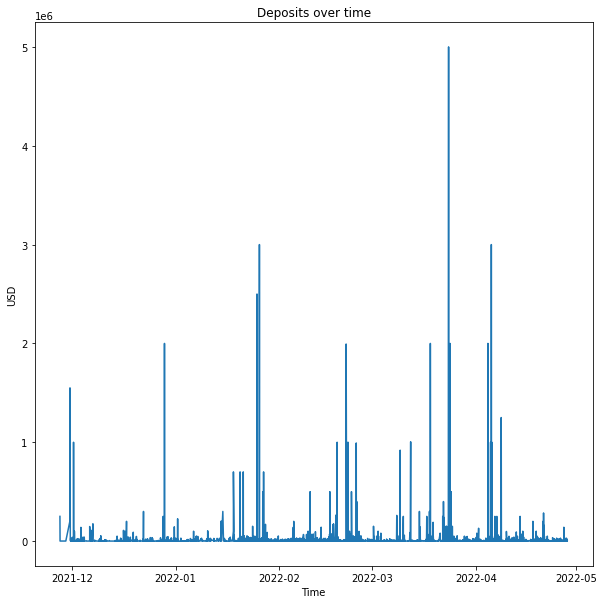

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.plot(deposits_df["time"], deposits_df["amount"])
ax.set_xlabel("Time")
ax.set_ylabel("USD")
ax.set_title("Deposits over time")
plt.show()

In [32]:
len(deposits_df["trader"].unique())

11977

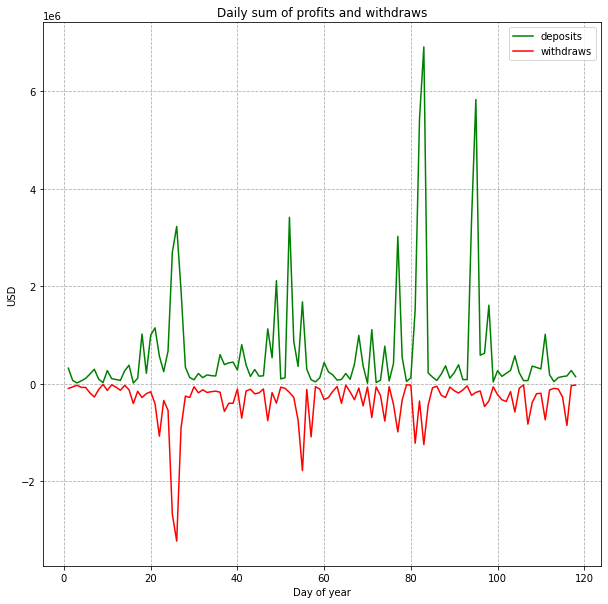

In [38]:
deposits_df["day_of_year"] = deposits_df["time"].dt.dayofyear
withdraws_df["day_of_year"] = withdraws_df["time"].dt.dayofyear

daily_grouped_deposits_df = deposits_df[["day_of_year", "amount"]].groupby("day_of_year").sum()
daily_grouped_withdraws_df = withdraws_df[["day_of_year", "amount"]].groupby("day_of_year").sum()

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(daily_grouped_deposits_df[daily_grouped_deposits_df.index < 200].index,
        daily_grouped_deposits_df[daily_grouped_deposits_df.index < 200]["amount"], 
        color='g', label='deposits')
ax.plot(daily_grouped_withdraws_df[daily_grouped_withdraws_df.index < 200].index,
        -daily_grouped_withdraws_df[daily_grouped_withdraws_df.index < 200]["amount"], 
        color='r', label='withdraws')
ax.set_xlabel("Day of year")
ax.set_ylabel("USD")
ax.set_title("Daily sum of profits and withdraws")
ax.grid(True, linestyle='--')
ax.legend()
plt.show()

In [29]:
deposits_df["amount"].sum()

83591322.704569

In [31]:
print("still available deposits sum = " + str(deposits_df["amount"].sum() - withdraws_df["amount"].sum()))

still available deposits sum = 40920640.640994


In [39]:
deposits_df.columns

Index(['id', 'tx_hash', 'trader', 'amount', 'block_number_log_index',
       'block_number', 'timestamp', 'time', 'day_of_year'],
      dtype='object')

In [40]:
withdraws_df.columns

Index(['id', 'tx_hash', 'trader', 'amount', 'block_number_log_index',
       'block_number', 'timestamp', 'time', 'day_of_year'],
      dtype='object')

# Setting unified tables for makers analysis

In [41]:
withdraws_df["amount"] = -withdraws_df["amount"]

In [46]:
investments_movement_df = pd.concat([withdraws_df, deposits_df])
investments_movement_df.sort_values(by=["timestamp"], inplace=True)
investments_movement_df.reset_index(inplace=True)
investments_movement_df.drop(columns=["index"], inplace=True)
investments_movement_df

,id,tx_hash,trader,amount,block_number_log_index,block_number,timestamp,time,day_of_year
0,0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...,0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,250000.000000,515551002,515551,1638000985,2021-11-27 08:16:25,331
1,0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...,0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...,0x98029c23e4a554989c280de7fcb1c2ededf2b17f,500.000000,516284002,516284,1638002723,2021-11-27 08:45:23,331
2,0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...,0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...,0x1313817a82545e29764281f51f6255619753235d,500.000000,516348002,516348,1638003246,2021-11-27 08:54:06,331
3,0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...,0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...,0xd087966b4d2b1841c88b4d62b407d5ef1a465ac3,500.000000,516415002,516415,1638003538,2021-11-27 08:58:58,331
4,0x02288555584fe8d00e6e4c596d286544647666a01eed...,0x02288555584fe8d00e6e4c596d286544647666a01eed...,0xc9735c7e0015fc9719f28306f90e530420f9b4ef,500.000000,516446002,516446,1638003768,2021-11-27 09:02:48,331
...,...,...,...,...,...,...,...,...,...
32113,0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...,0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...,0xfdf3b3b1cfe5f4967daba1719693d589ba790c1c,-1369.706620,6650269001,6650269,1651136454,2022-04-28 09:00:54,118
32114,0x5bf8f49846db7e917619a95f8804c4a48b1e0761f68e...,0x5bf8f49846db7e917619a95f8804c4a48b1e0761f68e...,0xbd96a914e932aff88a8529fb86d49314c6fafcea,14631.276264,6652910002,6652910,1651140296,2022-04-28 10:04:56,118
32115,0x7b66b2b90fc00d5abadadf3a75285298ed12888cfefe...,0x7b66b2b90fc00d5abadadf3a75285298ed12888cfefe...,0xbd96a914e932aff88a8529fb86d49314c6fafcea,-14705.195826,6653553004,6653553,1651141005,2022-04-28 10:16:45,118
32116,0x60c2c44ade6c07a1845b4103e110dbd2a1082f074164...,0x60c2c44ade6c07a1845b4103e110dbd2a1082f074164...,0xbb20d477d4f22d7169ad4c5bd67984362be8bad0,146.497910,6653693002,6653693,1651141101,2022-04-28 10:18:21,118


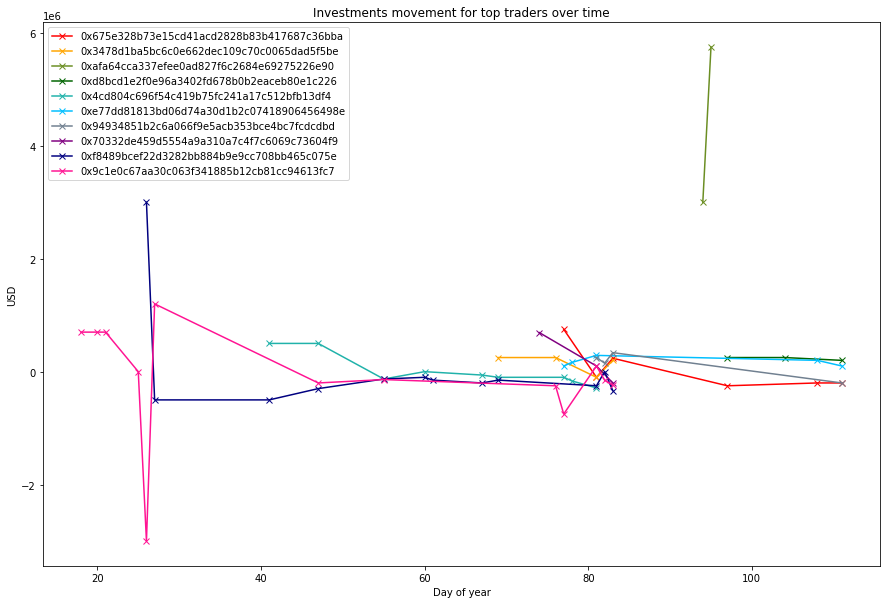

In [58]:
colors = ["red", "orange", "olivedrab", "darkgreen", "lightseagreen", 
          "deepskyblue", "slategray", "purple", "navy", "deeppink"]

fig, ax = plt.subplots(figsize=(15, 10))
index = 0

for maker in top_makers:
    maker_investments_movement_df = investments_movement_df[investments_movement_df["trader"] == maker]
    daily_maker_investments_movement_df = maker_investments_movement_df[["day_of_year", "amount"]
                                                                        ].groupby("day_of_year").sum()
    
    ax.plot(daily_maker_investments_movement_df[daily_maker_investments_movement_df.index < 200].index,
            daily_maker_investments_movement_df[daily_maker_investments_movement_df.index < 200]["amount"],
            color=colors[index], label=maker, marker='x')
    index += 1
    
ax.set_xlabel("Day of year")
ax.set_ylabel("USD")
ax.set_title("Investments movement for top traders over time")
ax.legend()

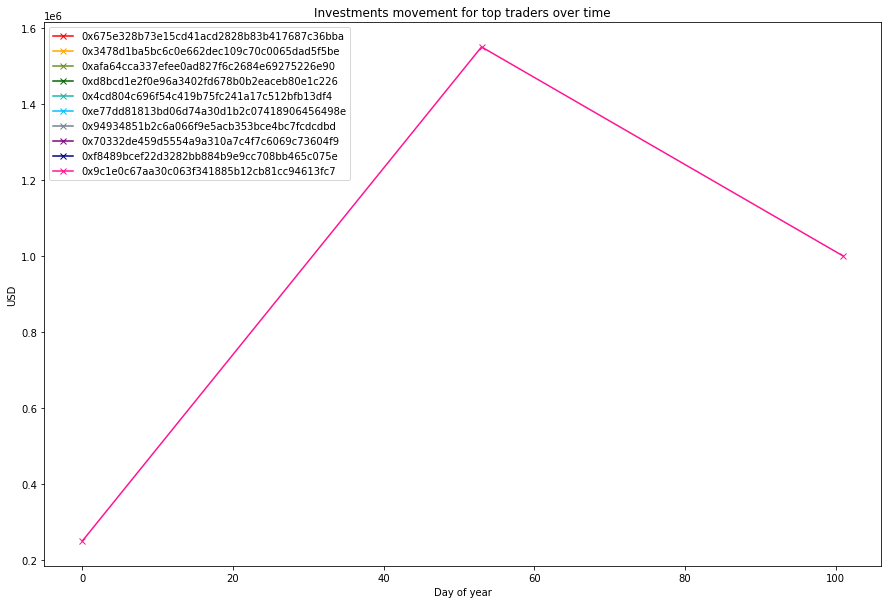

In [57]:
colors = ["red", "orange", "olivedrab", "darkgreen", "lightseagreen", 
          "deepskyblue", "slategray", "purple", "navy", "deeppink"]

fig, ax = plt.subplots(figsize=(15, 10))
index = 0

for maker in top_makers:
    maker_investments_movement_df = investments_movement_df[investments_movement_df["trader"] == maker]
    
    ax.plot(maker_investments_movement_df[maker_investments_movement_df.index < 200].index,
            maker_investments_movement_df[maker_investments_movement_df.index < 200]["amount"],
            color=colors[index], label=maker, marker='x')
    index += 1
    
ax.set_xlabel("Day of year")
ax.set_ylabel("USD")
ax.set_title("Investments movement for top traders over time")
ax.legend()
plt.show()